# Logistic Regression and Classification

In [1]:
import math
import random
import numpy as np
import pandas as pd
import scipy
import sympy
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

Logistic regression: predicts probability of an outcome given 1+ variables

Logistic regression is:
- trained on a discrete output variable (boolean or integer)
- resilient against outliers and other data challenges
- outputs a continuous value which can be convertd into a discrete value
- results in a curve indicating probability of an outcome

Classification: predicting categories <br>
logistic regression can be used for classification tasks by assigning a threshold to the logistic regression to predict belonging to a category (a probability below the threshold is classified as 0, above classified as 1)

A logistic regression uses the logistic function

Logistic function: sigmoid curve that produces an output between 0 and 1, for 1+ variables

The logistic function for outputting a probability $y$ for one input variable $x$:

$ y = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} = \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}$

$ \beta_0 + \beta_1 x $ is called a log-odds function

1.0/(1.0 + 16.8272567955368*exp(-0.62*x))


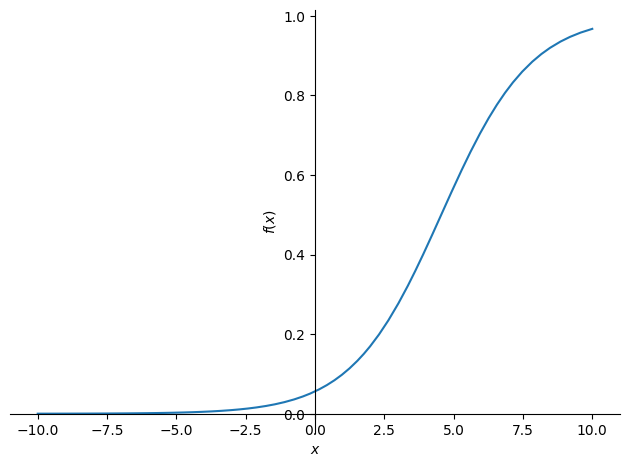

In [2]:
# plot logistic function

# define variables
b0, b1, x = sympy.symbols('b0 b1 x')
# define equation
p = 1.0 / (1.0 + sympy.exp(-(b0 + b1 * x)))
# substitute values
p = p.subs(b0, -2.823)
p = p.subs(b1, 0.620)
# display function
print(p)
sympy.plot(p);

Fitting a model requires an objective function. For logistic regression, that is a *maximum likelihood estimation*.

Maximum likelihood estimation (MLE): function maximizing likelihood that a given logistic curve would output the observed data

In [3]:
# fitting logistic regression from sklearn
url = 'https://bit.ly/33ebs2R'

# load data and extract input and output variables
patient_data = pd.read_csv(url)
X = patient_data.values[:, :-1]
y = patient_data.values[:, -1]

# fit logistic regression
model = LogisticRegression(penalty= None)
model.fit(X, y)

# print coefficients
print(model.coef_.flatten())
print(model.intercept_.flatten())

[0.69267212]
[-3.17576395]


apply gradient descent (GD) or SGD or mini-batch GD to solve MLE

Joint likelihood: likelihood of seeing all data points (or sample) for a given logistic regression curve.

$ \displaystyle\prod_{i=1}^{n} (\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{y_i} * (\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{1-y_i} $, where

$x_i$ is the data point input, and <br>
$y_i$ is the discrete output prediction (as a 1 or 0)

In [4]:
# calculate joint likelihood for fitted data

# get data and model
patient_data_iter = patient_data.itertuples()
b1 = model.coef_.flatten()[0]
b0 = model.intercept_.flatten()[0]

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# calculate joint likelihood
joint_likelihood = 1.0
for p in patient_data_iter:
    if p.y == 1.0:
        joint_likelihood *= logistic_function(p.x)
    elif p.y == 0.0:
        joint_likelihood *= (1.0 - logistic_function(p.x))

print(joint_likelihood)

4.791118022168743e-05


When a lot of mathematical calculation is done with computers, especially with very small numbers such as those from joint likelihood products, it is possible to experience *floating point underflow*.

Floating point underflow: when computer limits on floating point numbers affect numerical accuracy

to solve this problem for joint likelihood, take the log of the decimals, add them together, then raise the number back to the exponent of $e$ to convert back to joint likelihood. This form of calculation is more numerically stable.

joint likelihood = $ \displaystyle\sum_{i=1}^{n} log((\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{y_i} * (\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{1-y_i}) $

In [5]:
# calculate joint likelihood using logs

joint_likelihood = 0.0
patient_data_iter = patient_data.itertuples()
for p in patient_data_iter:
    joint_likelihood += math.log(
        logistic_function(p.x) ** p.y * \
        (1.0 - logistic_function(p.x)) ** (1.0 - p.y))
joint_likelihood = math.exp(joint_likelihood)
print(joint_likelihood)

4.791118022168748e-05


In [6]:
# use gradient descent for logistic regression

# get data
url = 'https://tinyurl.com/y2cocoo7'
points = list(pd.read_csv(url).itertuples())

# define variables
b1, b0, i, n = sympy.symbols('b1 b0 i n')
x, y = sympy.symbols('x y', cls=sympy.Function)

# calculate joint likelihood
joint_likelihood = sympy.Sum(sympy.log(
    (
        1.0 / \
        (1.0 + sympy.exp(-(b0 + b1 * x(i))))
    ) ** y(i) \
    * \
    (
        1.0 - \
        (
            1.0 / \
            (1.0 + sympy.exp(-(b0 + b1 * x(i))))
        )
    ) ** (1 - y(i))
), (i, 0, n))

# calculate partial derivatives
d_b1 = sympy.diff(joint_likelihood, b1) \
    .subs(n, len(points) - 1).doit() \
    .replace(x, lambda i: points[i].x) \
    .replace(y, lambda i: points[i].y)
d_b0 = sympy.diff(joint_likelihood, b0) \
    .subs(n, len(points) - 1).doit() \
    .replace(x, lambda i: points[i].x) \
    .replace(y, lambda i: points[i].y)
#lambdify for faster computation
d_b1 = sympy.lambdify([b1, b0], d_b1)
d_b0 = sympy.lambdify([b1, b0], d_b0)

# initialize parameters
b1 = 0.01
b0 = 0.01
L = 0.01

# perform gradient descent
for j in range(10_000):
    b1 += d_b1(b1, b0) * L
    b0 += d_b0(b1, b0) * L

print(b1, b0)

0.6926693075370812 -3.175751550409821


**DO NOT MAKE HAPHAZARD PREDICTIONS ON PEOPLE DATA**

seemingly benign variables can correlate with discriminatory variables

A good way to understand inputs is to understand outputs (what are the predictions being used for?)

In [7]:
# odds perspective calculation from logistic regression

hours_of_exposure = 6.0

def logistic_function(b0, b1, x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

p = logistic_function(b0, b1, hours_of_exposure)
print(p)

def odds(p):
    return p / (1-p)

odds_ = odds(p)

print(f'A patient is {round(odds_, 3)} times more likely to show symptoms than not show symptoms after {int(hours_of_exposure)} hours of exposure.')

0.7271606550610753
A patient is 2.665 times more likely to show symptoms than not show symptoms after 6 hours of exposure.


Wrapping the odds function in log yeilds the logit function.

$ log({\frac{p}{1-p}}) $

In [8]:
# get logit
logit = math.log(odds_)
print(logit)

0.9802642948126671


The logit function yields the same answer as the log-odds function.

$ log(\frac{p}{1-p}) = \beta_0 + \beta_1 x $

In [9]:
# get log-odds and show equality to logit
logodds = b0 + b1 * hours_of_exposure
print(logodds)
print(round(logit, 5) == round(logodds, 5))

0.9802642948126667
True


logarithms rescale odds so they are linear, making them easier to compare

odds ratios can compare effects of one x-value to another

$ O_a = \frac{p_a}{1 - p_a} $

$ O_b = \frac{p_b}{1 - p_b} $

odds ratio = $ {O_a \over O_b} $

where $a$ is (odds ratio) times more likely to happen than $b$.